In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys


P_PATH = os.getcwd()
print(os.listdir(P_PATH))

sys.path.append(P_PATH)

['results', 'tensorboard', 'src', 'temp_data', 'README.md', 'models', '.gitignore', 'exploration.ipynb', '.git', 'playground.ipynb', 'data', '.vscode', 'exploration_v2.ipynb']


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from src.data_loader import *

SCALEDOWN = 2
OBJ_NAME = 'chair'
BATCH_SIZE = 32
NUM_WORKERS = 4

img_size = int(800/SCALEDOWN)


min_max = None

#train dataset
train_dataset = SynDatasetRay(obj_name=OBJ_NAME, root_dir=P_PATH, split="train", img_size=img_size, num_points=8)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

min_max = train_dataset.min_max

print("train dataset size: ", len(train_dataset))


train dataset size:  16000000


/home/shao-yu-huang/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [5]:
#print the sample data shape
sample = train_dataset[0]

#sample is a dict with keys: rays_o, rays_d, points, z_vals, v_dir, img
for key in sample:
    print(key, sample[key].shape)


rays_o torch.Size([3])
rays_d torch.Size([3])
points torch.Size([8, 3])
z_vals torch.Size([8, 1])
v_dir torch.Size([2])
img torch.Size([3])


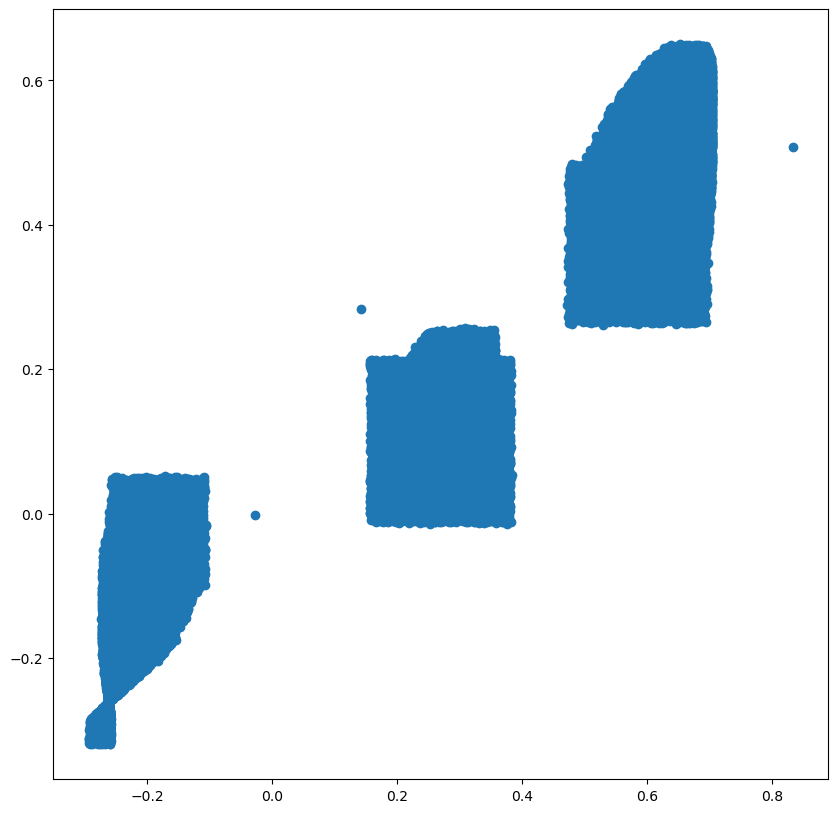

In [8]:
BATCH_SIZE = 160000
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
sample = next(iter(train_dataloader))

import numpy as np
#plot the sample data [points] in 2d
points = sample['points']

points = points.numpy()


plt.figure(figsize=(10,10))
plt.scatter(points[:, 0], points[:, 1])
plt.show()










